# **K-Means - Number of Clusters Set to Max Possible in Range**

In [120]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import ace_tools_open as tools
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [121]:
df = pd.read_csv('./products_to_package.csv')
df

,set,strike,notional
0,0,1.0035,1660000.0
1,0,1.0037,3480000.0
2,0,1.0054,450000.0
3,0,1.0077,460000.0
4,0,1.0095,1470000.0
...,...,...,...
396,9,1.0941,680000.0
397,9,1.0959,2470000.0
398,9,1.0963,470000.0
399,9,1.0969,390000.0


In [122]:
def fixed_cost(nominal):
    return 0.0006 * nominal if nominal <= 1_000_000 else 0.0003 * nominal

def curve_cost(nominal):
    return (11 - 0.5 * np.log(nominal)) / 10000 * nominal

In [123]:
def calculate_individual_cost(final_df):
    set_data = final_df.copy()
    set_data["fixed_cost"] = set_data["notional"].apply(fixed_cost)
    set_data["curve_cost"] = set_data["notional"].apply(curve_cost)
    set_data = set_data.groupby("set")[["fixed_cost", "curve_cost"]].sum().reset_index()
    return set_data

In [124]:
def plot_cost(final_df):
    set_data = calculate_individual_cost(final_df)
    final_df["set_cluster"] = final_df["set"].astype(str) + "-" + final_df["cluster"].astype(str)
    cluster_costs_per_set = final_df.copy()
    cluster_costs_per_set = cluster_costs_per_set.drop_duplicates(subset=["set_cluster"])
    cluster_costs_per_set = cluster_costs_per_set.groupby("set")[["fixed_cost", "curve_cost"]].sum().reset_index()

    # Plot 1: Cluster Transaction Costs
    plt.figure(figsize=(14, 6))
    plt.plot(final_df["set_cluster"], final_df["fixed_cost"], label="Fixed Cost", marker="o")
    plt.plot(final_df["set_cluster"], final_df["curve_cost"], label="Curve Cost", marker="s")
    plt.xticks(rotation=90, fontsize=8)
    plt.xlabel("(Set, Cluster) Pair")
    plt.ylabel("Transaction Cost")
    plt.title("Comparison of Transaction Cost Functions Across Clusters (Grouped by Set)")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 2: Comparison Against Individual Costs
    plt.figure(figsize=(12, 6))
    plt.bar(cluster_costs_per_set["set"], cluster_costs_per_set["fixed_cost"], alpha=0.6, label="Sum of Fixed Costs (Clusters)", color="blue")
    plt.bar(cluster_costs_per_set["set"], cluster_costs_per_set["curve_cost"], alpha=0.6, label="Sum of Curve Costs (Clusters)", color="orange")

    for set_id, row in set_data.iterrows():
        plt.hlines(y=row["fixed_cost"], xmin=set_id - 0.4, xmax=set_id + 0.4, linestyle="--", color="blue", alpha=0.8, label="Sum of Individual Fixed Cost" if set_id == 0 else "")
        plt.hlines(y=row["curve_cost"], xmin=set_id - 0.4, xmax=set_id + 0.4, linestyle="--", color="red", alpha=0.8, label="Sum of Individual Curve Cost" if set_id == 0 else "")

    plt.xticks(cluster_costs_per_set["set"])
    plt.xlabel("Set")
    plt.ylabel("Total Transaction Cost")
    plt.title("Comparison of Cluster-Based vs. Individual Set Transaction Costs")
    plt.legend()
    plt.grid()
    plt.show()

In [125]:
def apply_kmeans_grouping(max_dist):
    grouped_data = []
    
    for set_id in df['set'].unique():
        subset = df[df['set'] == set_id].copy()
        strikes = subset['strike'].values.reshape(-1, 1)
        
        if max_dist:
            n_clusters = max(1, int((subset['strike'].max() - subset['strike'].min()) / max_dist))
        else:
            n_clusters = len(subset)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        subset['cluster'] = kmeans.fit_predict(strikes)
        
        cluster_mapping = subset.groupby("cluster").apply(
            lambda x: pd.Series({
                "grouped_strike": np.average(x["strike"], weights=x["notional"]),
                "cluster_notional": x["notional"].sum()
            })
        ).reset_index()
        merged = subset.merge(cluster_mapping, on='cluster', how='left')
        grouped_data.append(merged)
    final_df = pd.concat(grouped_data)
    final_df = final_df.sort_values(by=['set', 'cluster'])
    final_df["fixed_cost"] = final_df["cluster_notional"].apply(fixed_cost)
    final_df["curve_cost"] = final_df["cluster_notional"].apply(curve_cost)
    tools.display_dataframe_to_user(name=f'K-Means Clustering Result max_dist={max_dist}', dataframe=final_df)
    inertia_per_set = {}
    silhouette_per_set = {}

    for set_id, group in final_df.groupby("set"):
        strikes = group["strike"].values.reshape(-1, 1)
        labels = group["cluster"]

        # Compute Inertia
        cluster_centers = group.groupby("cluster")["strike"].mean()
        inertia = sum((strikes.flatten() - cluster_centers[labels].values) ** 2)
        inertia_per_set[set_id] = inertia

        # Compute Silhouette Score
        try:
            silhouette_per_set[set_id] = silhouette_score(strikes, labels)
        except:
            silhouette_per_set[set_id] = np.nan

    print('Inertia:', sum(inertia_per_set.values()))
    print('Silhouette Score:', np.nanmean(list(silhouette_per_set.values())))
    plot_cost(final_df)

K-Means Clustering Result max_dist=0.02


Inertia: 0.01646454363698803
Silhouette Score: 0.6175673387744197


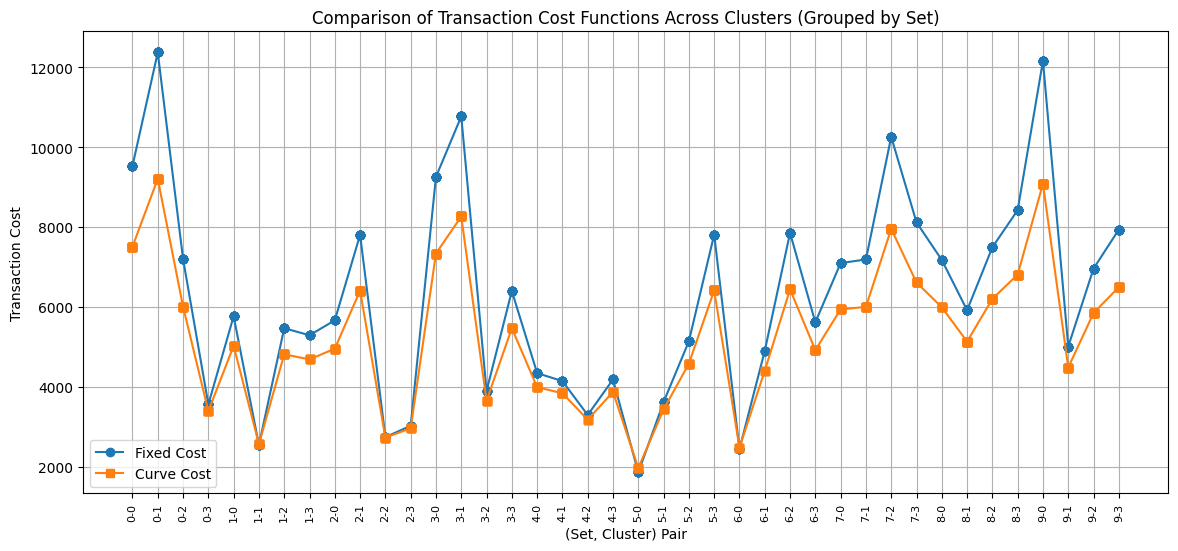

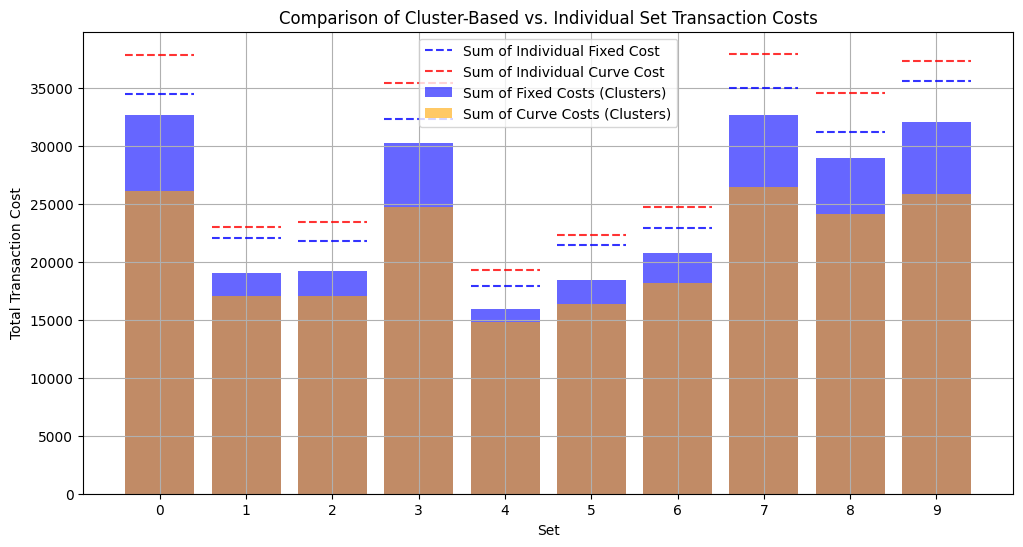

K-Means Clustering Result max_dist=0.03


Inertia: 0.03657213097048936
Silhouette Score: 0.6349576050198833


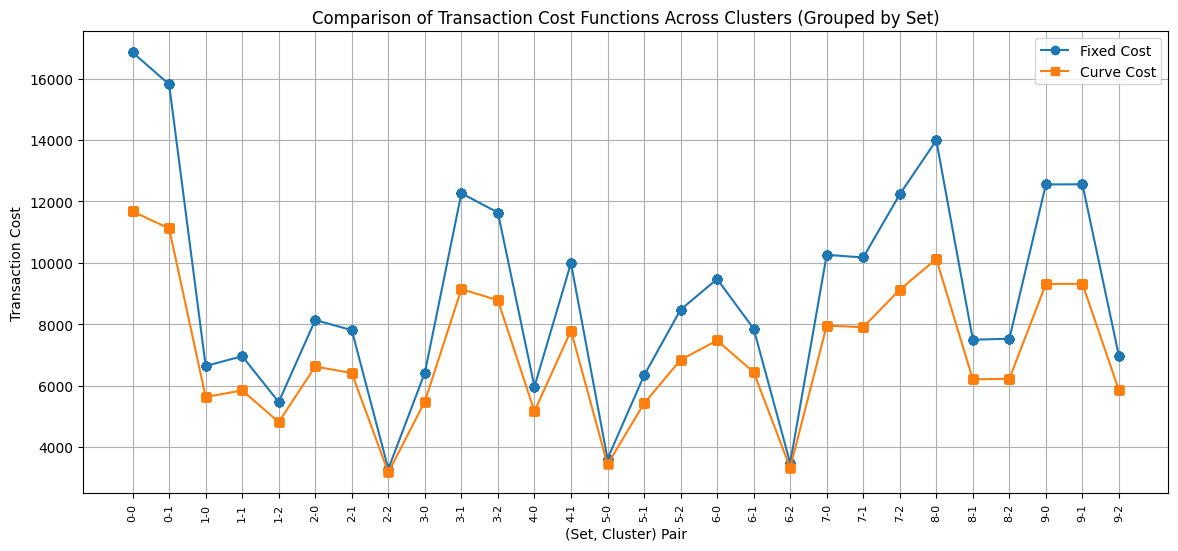

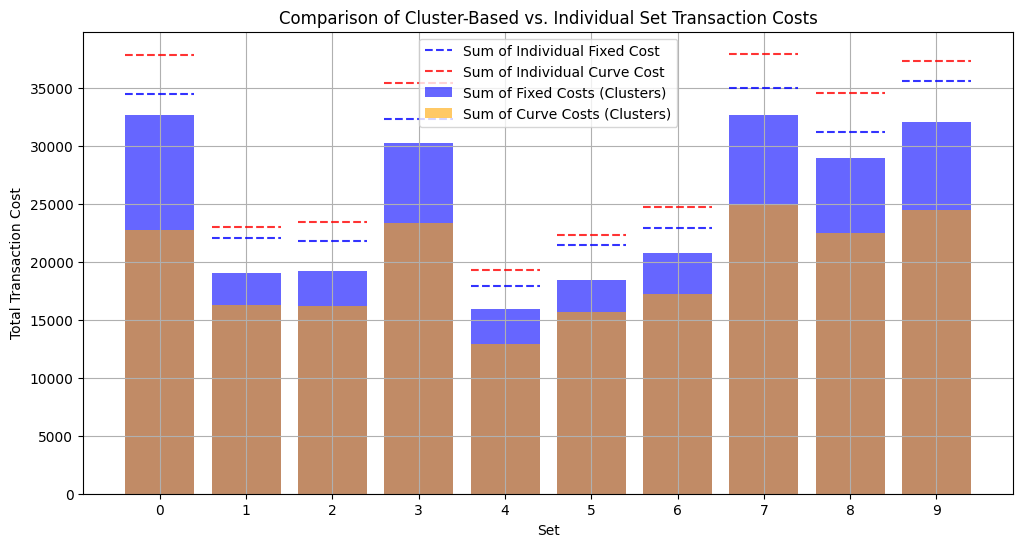

K-Means Clustering Result max_dist=0.04


Inertia: 0.0730024202514604
Silhouette Score: 0.6492533406529496


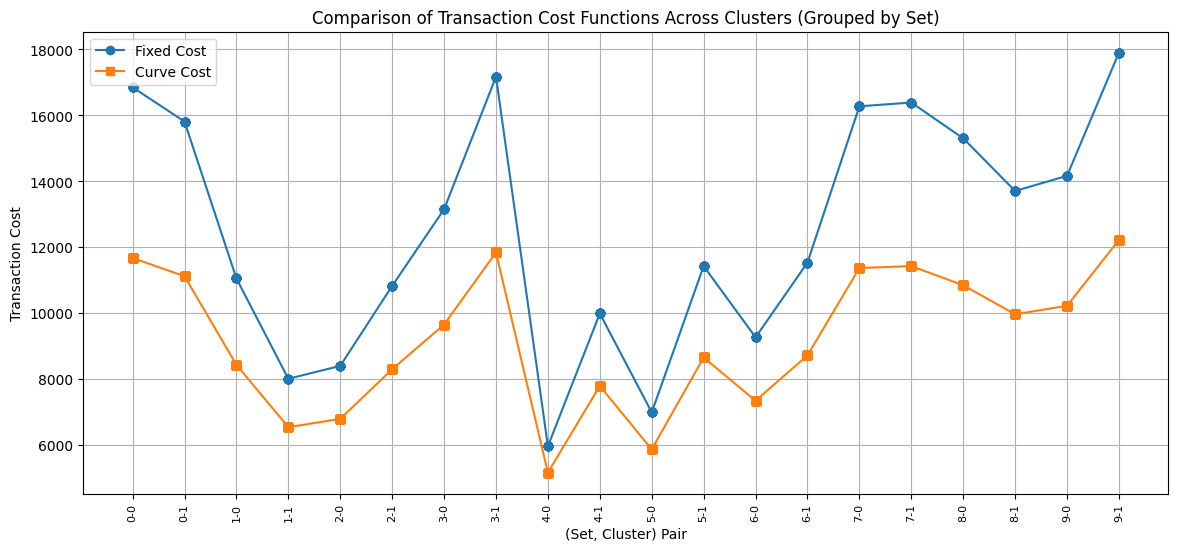

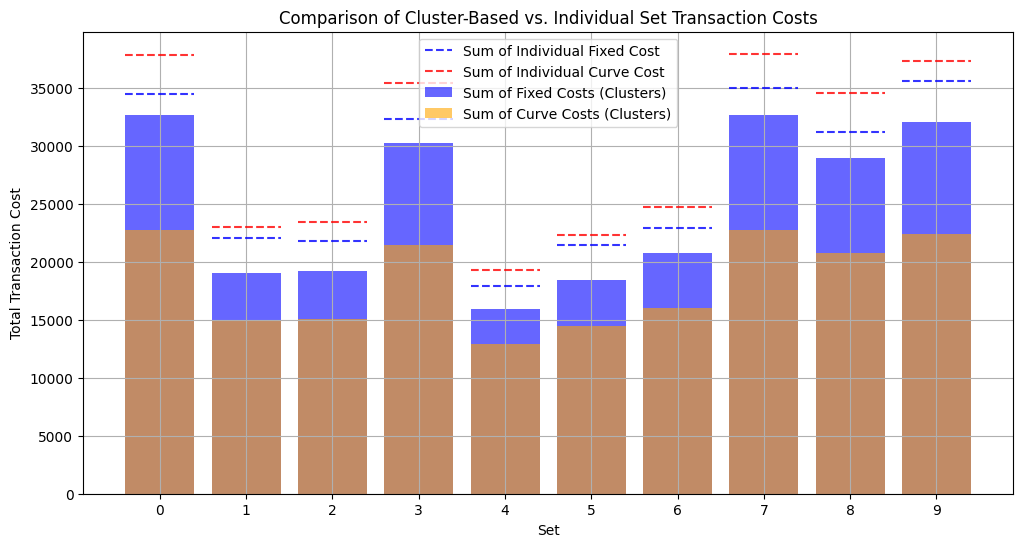

K-Means Clustering Result max_dist=None


Inertia: 0.0
Silhouette Score: 0.069564753801207


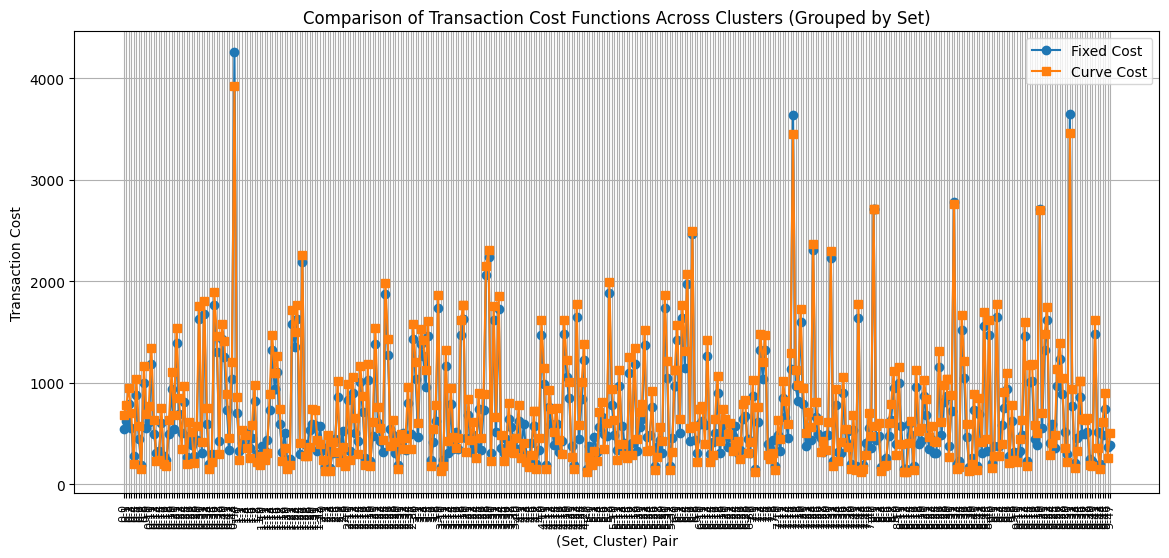

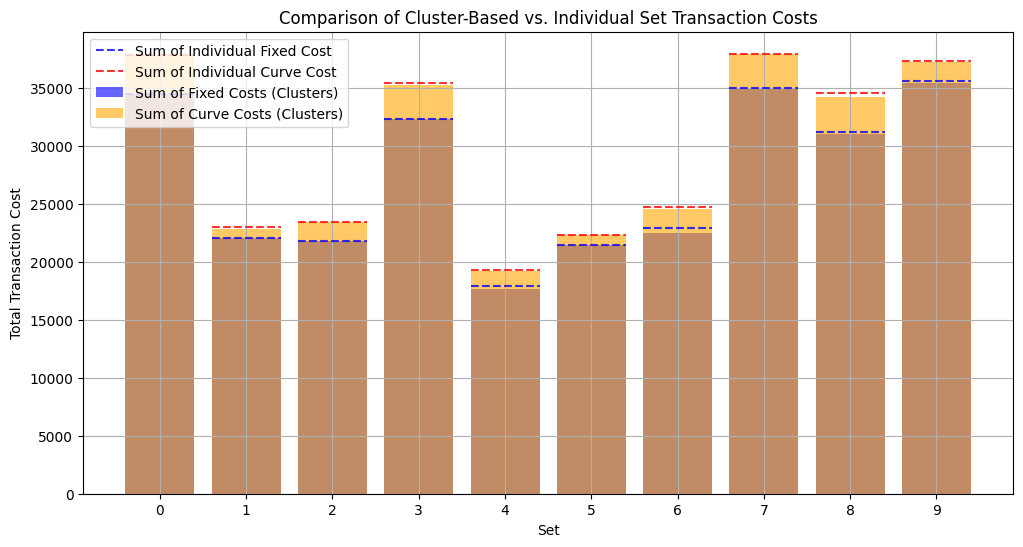

In [126]:
max_distances = [0.02, 0.03, 0.04, None]

for max_dist in max_distances:
    apply_kmeans_grouping(max_dist)